In [1]:
import pandas as pd
import numpy as np
from sklearn.datasets import load_iris
from sklearn.linear_model import Perceptron
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import matplotlib.pyplot as plt

from keras import activations
from keras import backend as K
from functools import partial
import tensorflow as tf
from tensorflow import keras
print("TensorFlow version:", tf.__version__)
print("Keras version:", keras.__version__)

2023-01-02 14:38:26.805330: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-02 14:38:28.164735: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-01-02 14:38:28.164879: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-01-02 14:38:28.164894: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

TensorFlow version: 2.11.0
Keras version: 2.11.0


In [2]:
 #!pip install --upgrade tensorflow-gpu 

     |████████████████████████████████| 588.3 MB 5.1 kB/s  eta 0:00:0104
     |████████████████████████████████| 6.0 MB 67.6 MB/s eta 0:00:01
     |████████████████████████████████| 439 kB 68.7 MB/s eta 0:00:01
     |████████████████████████████████| 1.1 MB 63.6 MB/s eta 0:00:01
     |████████████████████████████████| 124 kB 64.7 MB/s eta 0:00:01
     |████████████████████████████████| 1.7 MB 60.6 MB/s eta 0:00:01
     |████████████████████████████████| 2.4 MB 69.6 MB/s eta 0:00:01
     |████████████████████████████████| 14.1 MB 54.7 MB/s eta 0:00:01
ERROR: tensorflow 2.2.1 has requirement h5py<2.11.0,>=2.10.0, but you'll have h5py 3.7.0 which is incompatible.
ERROR: tensorflow 2.2.1 has requirement numpy<1.19.0,>=1.16.0, but you'll have numpy 1.21.6 which is incompatible.
ERROR: tensorflow 2.2.1 has requirement tensorboard<2.3.0,>=2.2.0, but you'll have tensorboard 2.11.0 which is incompatible.
ERROR: tensorflow 2.2.1 has requirement tensorflow-estimator<2.3.0,>=2.2.0, but you'll have

In [5]:
 #tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:
fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

#class_names = ['Polo/Top', 'Pantalon', 'Sueter', 'Vestido','Casaca', 'Sandálias','Camisas', 'Zapatilla', 'Bolsa', 'Botas']

4422102/4422102 [==============================] - 0s 0us/step


In [3]:
X_valid, X_train = X_train_full[:5000] / 255.0, X_train_full[5000:] / 255.0
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test /255

In [4]:
#Para convertir de (60000, 28, 28) a (60000, 28, 28, 1)
X_train = tf.expand_dims(X_train, axis=-1)
X_train.shape

2023-01-02 14:38:43.637117: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-02 14:38:44.616385: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10784 MB memory:  -> device: 0, name: Tesla K80, pci bus id: 0001:00:00.0, compute capability: 3.7


TensorShape([55000, 28, 28, 1])

In [6]:
class ResidualUnit(keras.layers.Layer):
    def __init__(self, filters, strides=1, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)
        self.main_layers = [
            keras.layers.Conv2D(filters, 3, strides=strides,padding="same", use_bias=False),
            keras.layers.BatchNormalization(),
            self.activation,
            keras.layers.Conv2D(filters, 3, strides=1,padding="same", use_bias=False),
            keras.layers.BatchNormalization()]
        self.skip_layers = []
        if strides > 1:
            self.skip_layers = [
                keras.layers.Conv2D(filters, 1, strides=strides, padding="same", use_bias=False),
                keras.layers.BatchNormalization()]

    def call(self, inputs):
        Z = inputs
        for layer in self.main_layers:
            Z = layer(Z)
        skip_Z = inputs
        for layer in self.skip_layers:
            skip_Z = layer(skip_Z)
        return self.activation(Z + skip_Z)

In [7]:
model = keras.models.Sequential()
model.add(keras.layers.Conv2D(64, 7, strides=2, input_shape=[28, 28, 1],
                              padding="same", use_bias=False))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation("relu"))
model.add(keras.layers.MaxPool2D(pool_size=3, strides=2, padding="same"))
prev_filters = 64
for filters in [64] * 3 + [128] * 4 + [256] * 6 + [512] * 3:
    strides = 1 if filters == prev_filters else 2
    model.add(ResidualUnit(filters, strides=strides))
    prev_filters = filters
model.add(keras.layers.GlobalAvgPool2D())
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(10, activation="softmax"))

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 64)        3136      
                                                                 
 batch_normalization (BatchN  (None, 14, 14, 64)       256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 14, 14, 64)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 7, 7, 64)         0         
 )                                                               
                                                                 
 residual_unit (ResidualUnit  (None, 7, 7, 64)         74240     
 )                                                               
                                                        

In [9]:
optimizer = keras.optimizers.SGD(lr=0.01)
model.compile(loss = "sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

my_callbacks = [tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),]
history = model.fit(X_train, 
                    y_train, 
                    epochs=100, 
                    validation_data=(X_valid, y_valid),
                    callbacks=my_callbacks)

2023-01-02 14:39:48.040961: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8201
2023-01-02 14:40:18.031068: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-01-02 14:40:42.159101: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x55c291f5d150 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-01-02 14:40:42.159142: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): Tesla K80, Compute Capability 3.7
2023-01-02 14:40:42.183122: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-01-02 14:40:42.236442: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Epoch 1/100
1719/1719 [==============================] - 211s 73ms/step - loss: 0.5527 - accuracy: 0.8057 - val_loss: 0.3362 - val_accuracy: 0.8798
Epoch 2/100
1719/1719 [==============================] - 123s 72ms/step - loss: 0.3305 - accuracy: 0.8793 - val_loss: 0.3017 - val_accuracy: 0.8898
Epoch 3/100
1719/1719 [==============================] - 123s 72ms/step - loss: 0.2858 - accuracy: 0.8954 - val_loss: 0.2800 - val_accuracy: 0.8948
Epoch 4/100
1719/1719 [==============================] - 123s 72ms/step - loss: 0.2509 - accuracy: 0.9071 - val_loss: 0.2592 - val_accuracy: 0.9048
Epoch 5/100
1719/1719 [==============================] - 123s 72ms/step - loss: 0.2260 - accuracy: 0.9159 - val_loss: 0.2554 - val_accuracy: 0.9046
Epoch 6/100
1719/1719 [========================

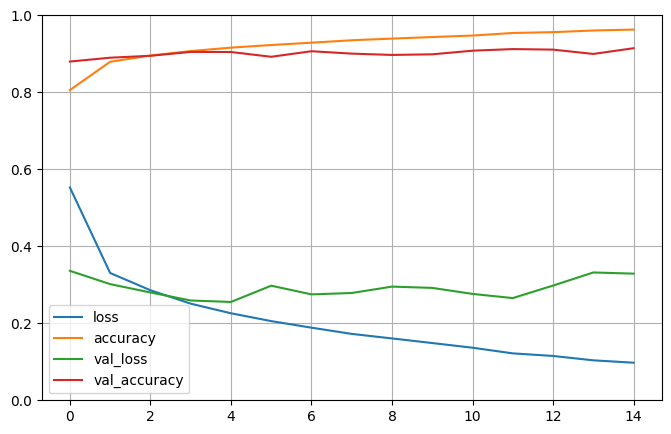

Test loss: 0.2725507318973541
Test accuracy: 0.8970999717712402


In [11]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

model_Resnet_score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', model_Resnet_score[0])
print('Test accuracy:', model_Resnet_score[1])

In [10]:
model_name = "Resnet_Intento1.h5"
model.save(model_name)

In [13]:
import os
os.getcwd()

'/mnt/batch/tasks/shared/LS_root/mounts/clusters/consultaexterna1/code/Users/consultaexterna'

In [15]:
import pickle

with open('/mnt/batch/tasks/shared/LS_root/mounts/clusters/consultaexterna1/code/Users/consultaexterna/Resnet_Intento1.pickle', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)